In [1]:
import pickle

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from inceptionresnet import inceptionresnetv2

In [3]:
from object_detection_utils.object_detection_helper import *
from object_detection_utils.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_utils.RetinaNet import RetinaNet
from object_detection_utils.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

In [4]:
import fastai.utils.collect_env
fastai.utils.collect_env.check_perf()

Running performance checks.

*** libjpeg-turbo status
❓ libjpeg-turbo's status can't be derived - need Pillow(-SIMD)? >= 5.4.0 to tell, current version 5.3.0.post1

*** Pillow-SIMD status
✔ Running Pillow-SIMD 5.3.0.post1

*** CUDA status
✔ Running the latest CUDA 9.0.176 with NVIDIA driver 396.54

Refer to https://docs.fast.ai/performance.html to make sense out of these checks and suggestions.


In [5]:
torch.cuda.empty_cache()

In [6]:
# could improve performance (not tested with fastai)
torch.backends.cudnn.enabled = True 

### Check dataset 

In [7]:
path = Path('data/ILSVRC/Data/CLS-LOC')
annotation_path = Path('data/ILSVRC/Annotations/CLS-LOC')

In [8]:
os.listdir(path)

['export',
 'imagenet_199px_object_detection.pkl',
 'imagenet_256px_object_detection.pkl',
 'imagenet_256px_object_detection_smoll.pkl',
 'imagenet_256px_object_detection_smoller.pkl',
 'imagenet_299px_object_detection.pkl',
 'models',
 'test',
 'train',
 'valid']

In [9]:
len(os.listdir(path/'train'))

1000

In [10]:
os.listdir(path/'train')[:5]

['n02093859', 'n01440764', 'n01443537', 'n01484850', 'n01491361']

In [11]:
len(os.listdir(path/'valid'))

50000

In [12]:
os.listdir(path/'valid')[:5]

['ILSVRC2012_val_00000007.JPEG',
 'ILSVRC2012_val_00000008.JPEG',
 'ILSVRC2012_val_00000009.JPEG',
 'ILSVRC2012_val_00000010.JPEG',
 'ILSVRC2012_val_00000011.JPEG']

In [13]:
len(os.listdir(path/'test'))

100000

In [14]:
os.listdir(path/'test')[:5]

['ILSVRC2012_test_00026354.JPEG',
 'ILSVRC2012_test_00000007.JPEG',
 'ILSVRC2012_test_00000008.JPEG',
 'ILSVRC2012_test_00000009.JPEG',
 'ILSVRC2012_test_00000010.JPEG']

In [15]:
os.listdir(annotation_path)[:5]

['train', 'valid']

In [16]:
len(os.listdir(annotation_path/'train'))

1000

In [17]:
os.listdir(annotation_path/'train')[:5]

['n02093859', 'n01440764', 'n01443537', 'n01484850', 'n01491361']

In [18]:
os.listdir(annotation_path/'train/n01440764')[:5]

['n01440764_4167.xml',
 'n01440764_10548.xml',
 'n01440764_10569.xml',
 'n01440764_10587.xml',
 'n01440764_10592.xml']

In [19]:
len(os.listdir(annotation_path/'valid'))

50000

In [20]:
os.listdir(annotation_path/'valid')[:5]

['ILSVRC2012_val_00000006.xml',
 'ILSVRC2012_val_00000007.xml',
 'ILSVRC2012_val_00000008.xml',
 'ILSVRC2012_val_00000009.xml',
 'ILSVRC2012_val_00000010.xml']

In [21]:
os.listdir(annotation_path/'valid')[0]

'ILSVRC2012_val_00000006.xml'

### extract annotations

In [22]:
#path

In [23]:
#import xml.etree.ElementTree as ET

In [24]:
#fnames = []
#lbl_bboxes = []

In [25]:
#val_path = f'{annotation_path}/valid/'
#train_path = f'{annotation_path}/train/'

In [26]:
#for annotation in os.listdir(val_path):   
#    bboxes = []
#    root = ET.parse(val_path+annotation).getroot()
#
#    bbox_tag = root.findall('object/bndbox')
#    xmin = [r.find('xmin').text for r in bbox_tag]
#    ymin = [r.find('ymin').text for r in bbox_tag]
#    xmax = [r.find('xmax').text for r in bbox_tag]
#    ymax = [r.find('ymax').text for r in bbox_tag]
#
#    for i in range(0, len(bbox_tag)):
#        bboxes.append([int(ymin[i]), int(xmin[i]), int(ymax[i]), int(xmax[i])])
#
#    obj_tag = root.findall('object')
#    category = [r.find('name').text for r in obj_tag]
#
#    fname_tag = root.findall('filename')
#    fname = fname_tag[0].text + '.JPEG' 
#    fnames += ['valid' + '/' + fname]
#
#    lbl_bboxes.append([bboxes, category])

In [27]:
#len(lbl_bboxes)

In [28]:
#for folder in os.listdir(train_path):
#    for annotation in os.listdir(train_path + folder):
#        bboxes = []
#        root = ET.parse(f'{train_path}{folder}/{annotation}').getroot()
#
#        bbox_tag = root.findall('object/bndbox')
#        xmin = [r.find('xmin').text for r in bbox_tag]
#        ymin = [r.find('ymin').text for r in bbox_tag]
#        xmax = [r.find('xmax').text for r in bbox_tag]
#        ymax = [r.find('ymax').text for r in bbox_tag]
#
#        for i in range(0, len(bbox_tag)):
#            bboxes.append([int(ymin[i]), int(xmin[i]), int(ymax[i]), int(xmax[i])])
#
#        obj_tag = root.findall('object')
#        category = [r.find('name').text for r in obj_tag]
#
#        fname_tag = root.findall('filename')
#        fname = fname_tag[0].text + '.JPEG' 
#        fnames += ['train/' + folder + '/' + fname]
#        lbl_bboxes.append([bboxes, category])

In [29]:
#fname2bbox = dict(zip(fnames, lbl_bboxes))

In [30]:
#dict(list(fname2bbox.items())[0:4])

In [31]:
#len(fname2bbox)

In [32]:
#with open('fname2bbox.p', 'wb') as fp:
#    pickle.dump(fname2bbox, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
with open('fname2bbox.p', 'rb') as fp:
    fname2bbox = pickle.load(fp)

### define metric 

In [34]:
def top_5_accuracy(input, targs, k=5):
    return top_k_accuracy(input, targs, k)

### for the full ILSV2017 classification dataset

In [35]:
def path2fn(path):
    if 'val' in path:
        return re.search('\w*\/\w*\.JPEG$', path).group(0)
    else:
        return re.search('\w*\/\w*\/\w*\.JPEG$', path).group(0)

In [36]:
get_y_func = lambda o: fname2bbox[path2fn(o)]

In [37]:
size = 256

In [38]:
train_df = pd.DataFrame(data=list(fname2bbox.keys()))

In [40]:
data_bunch = (ObjectItemList.from_df(train_df, path=path)
                           .use_partial_data(0.012)
                           .split_by_rand_pct(valid_pct=0.2, seed=21)
                           #.split_by_valid_func(val_split)
                           .label_from_func(get_y_func)
                           .transform(get_transforms(), tfm_y=True, size=size)
                           .databunch(bs=8, collate_fn=bb_pad_collate)
                           .normalize(imagenet_stats))

In [41]:
data_bunch.save('imagenet_256px_object_detection_smoller.pkl')

### if the databunch has been saved

In [42]:
#size = 256

In [43]:
#data_bunch = load_data('data/ILSVRC/Data/CLS-LOC', 'imagenet_256px_object_detection_smoll.pkl', 
#                       collate_fn=bb_pad_collate, bs=8, num_workers=8)

### quick look at the images

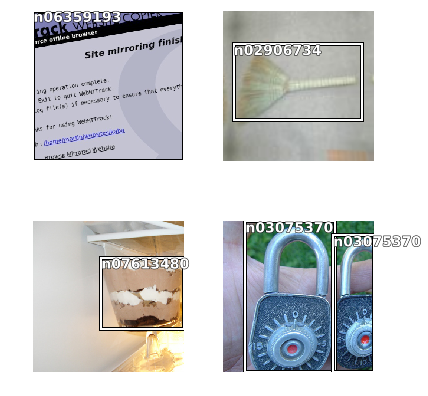

In [44]:
data_bunch.show_batch(rows=2, figsize=(6,6))

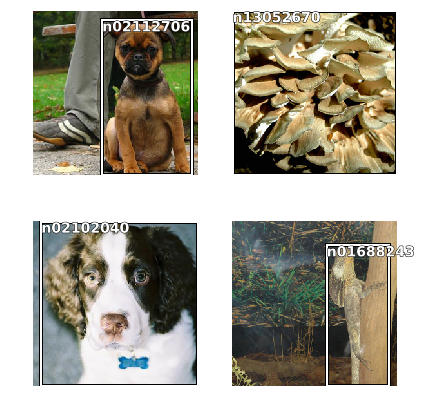

In [45]:
data_bunch.show_batch(rows=2, figsize=(6,6), ds_type=DatasetType.Valid)

## creating anchors

In [46]:
anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)], ratios=[0.5, 1, 2], scales=[0.35, 0.5, 0.6, 1, 1.25, 1.6])

In [47]:
#anchors = create_anchors(sizes=[(32,32),(16,16)], ratios=[0.5, 1], scales=[0.35, 0.5, 0.6, 1])

In [48]:
#anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.35, 0.5, 0.6])

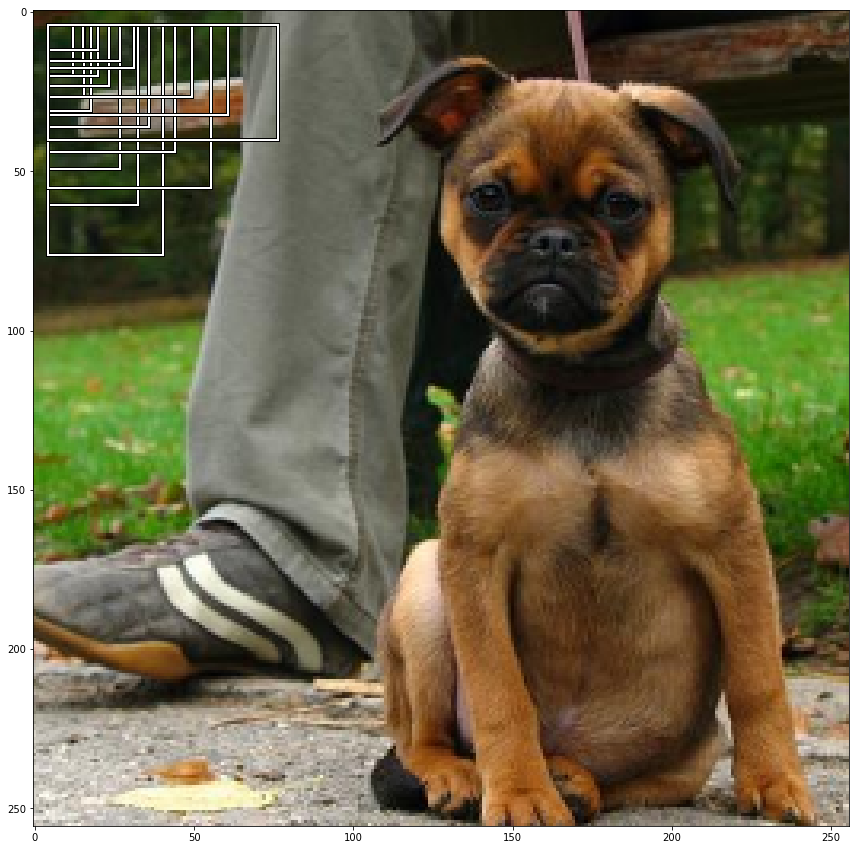

In [49]:
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(image2np(data_bunch.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:18]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

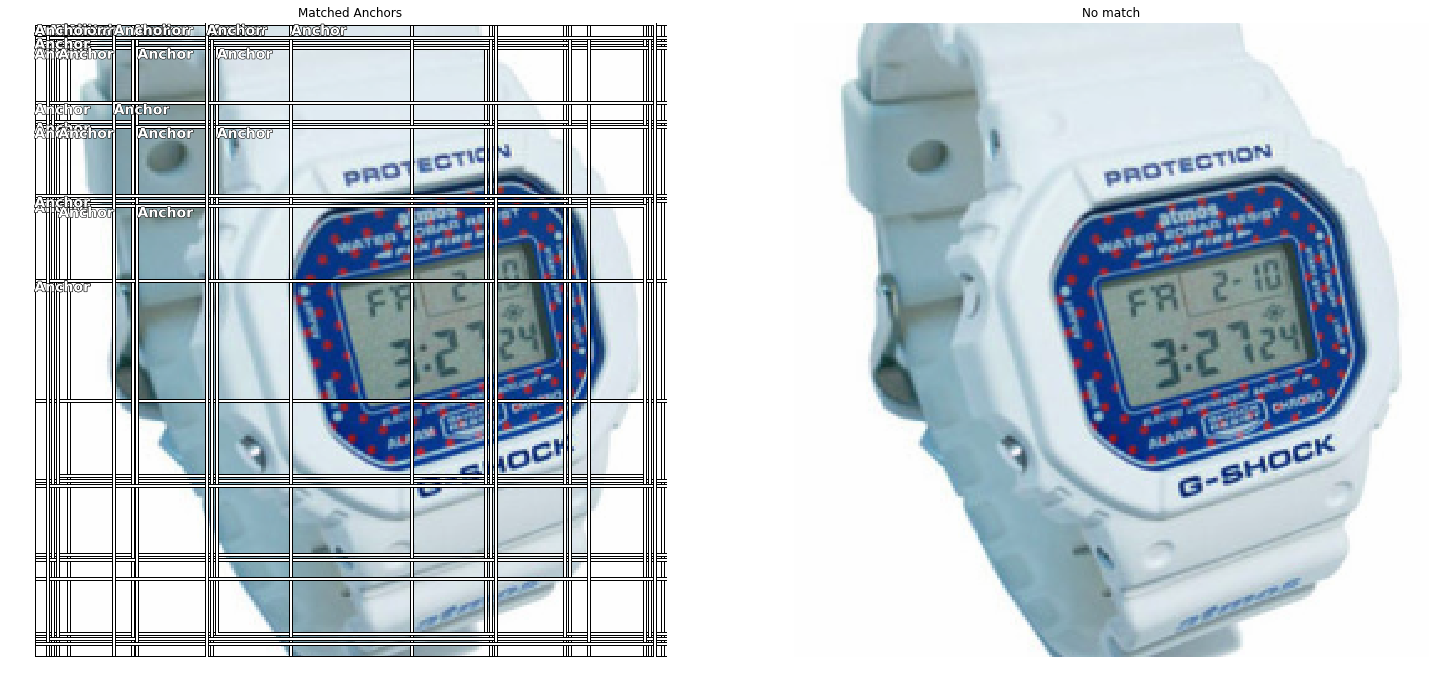

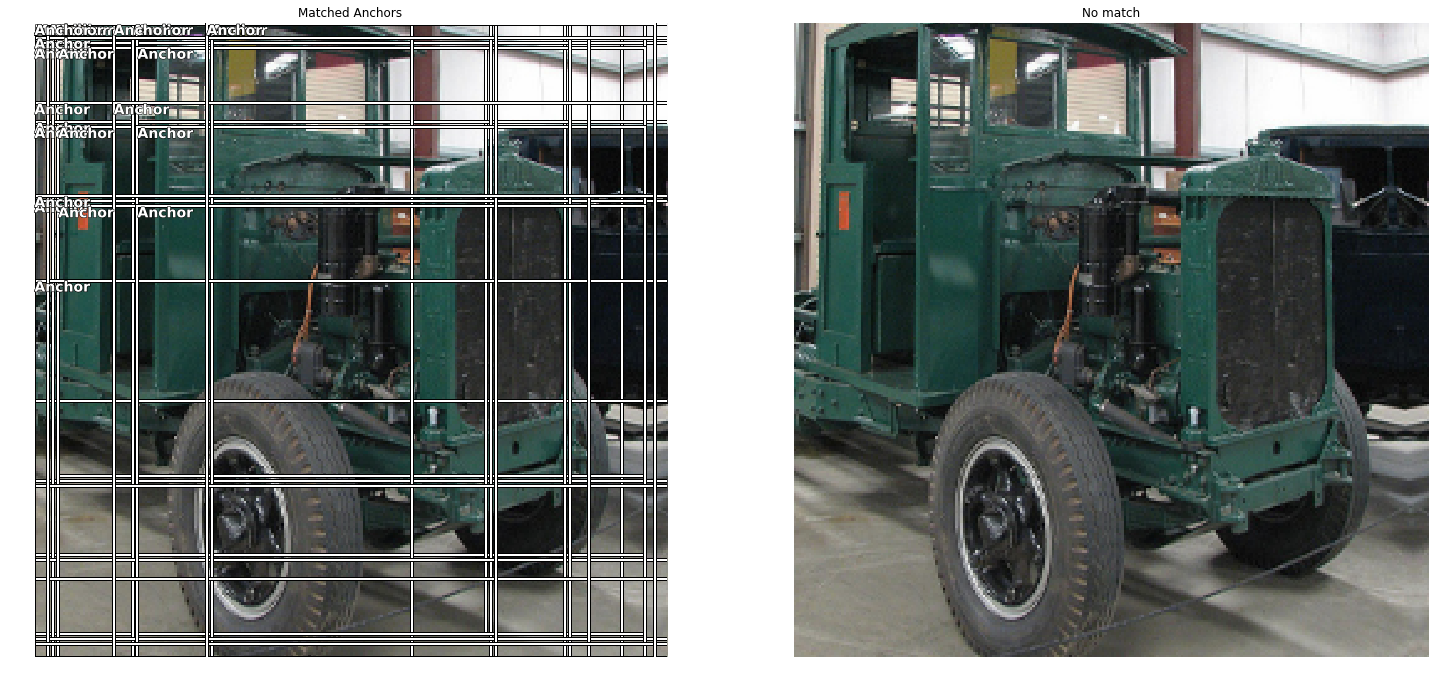

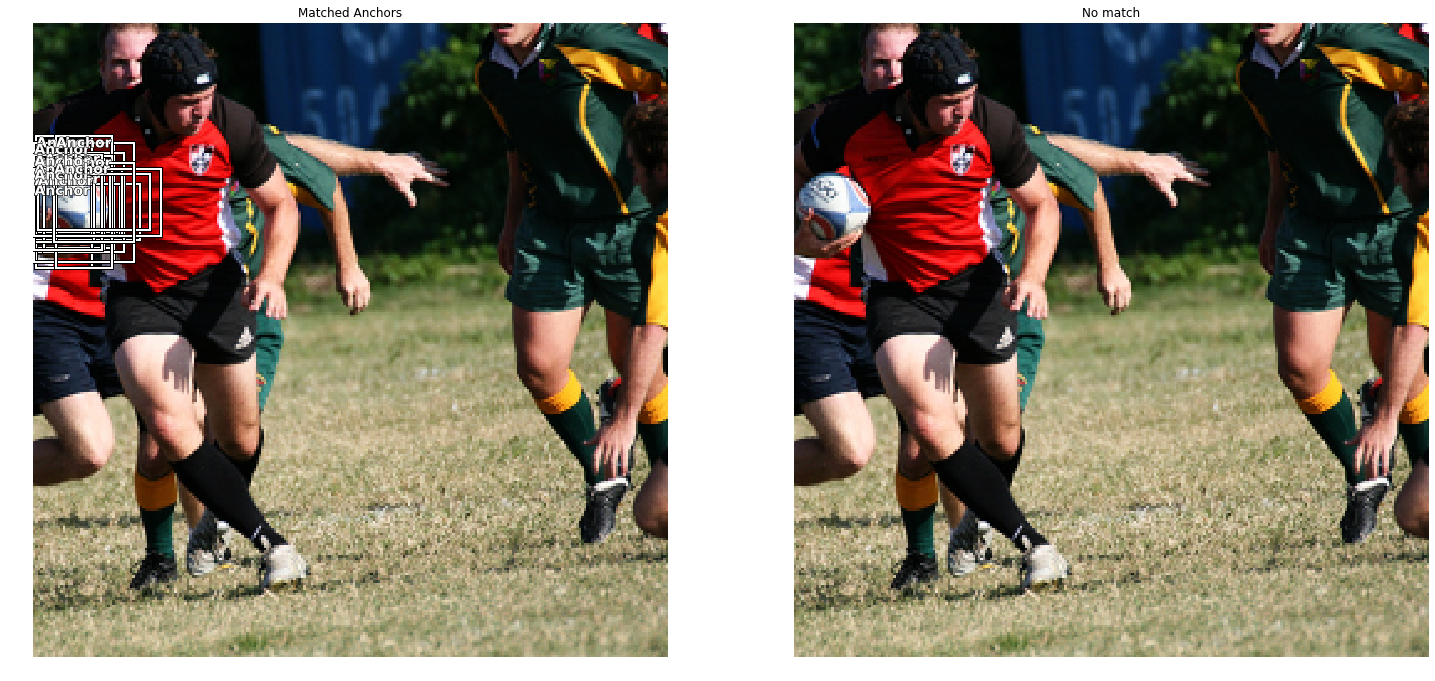

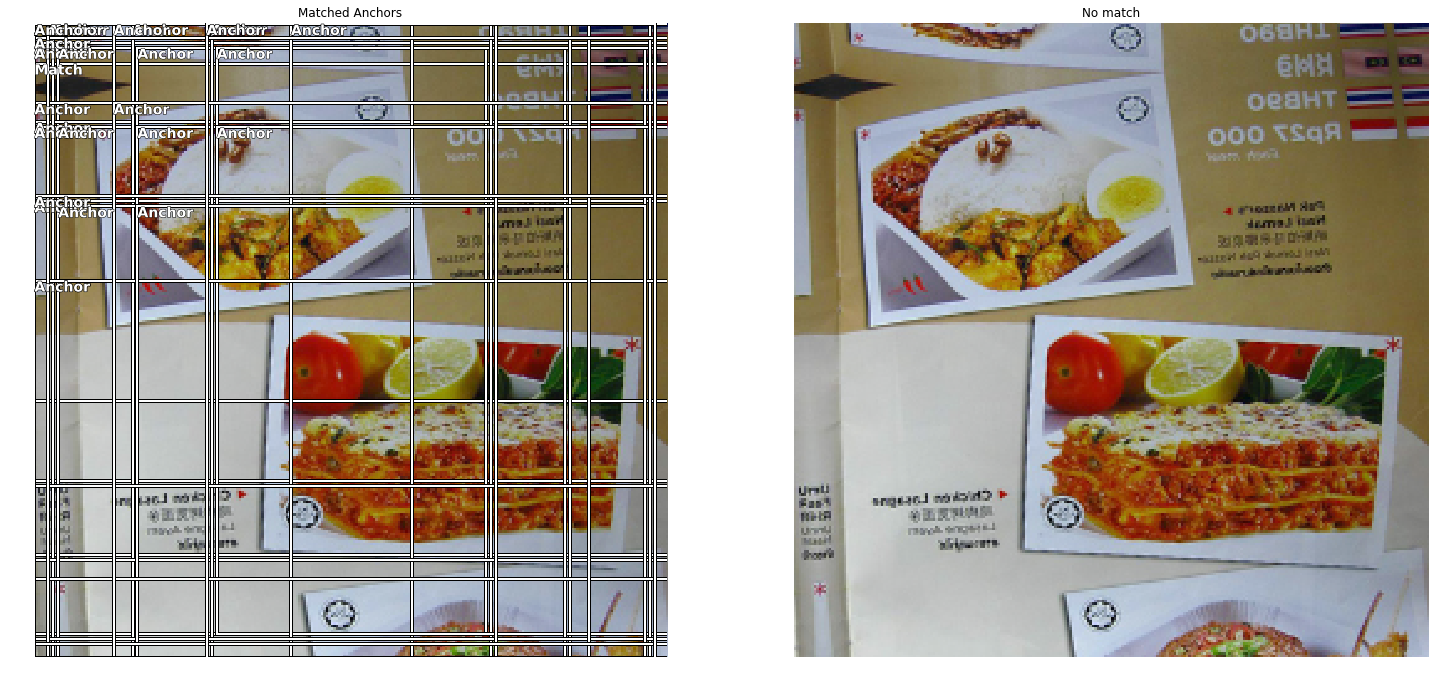

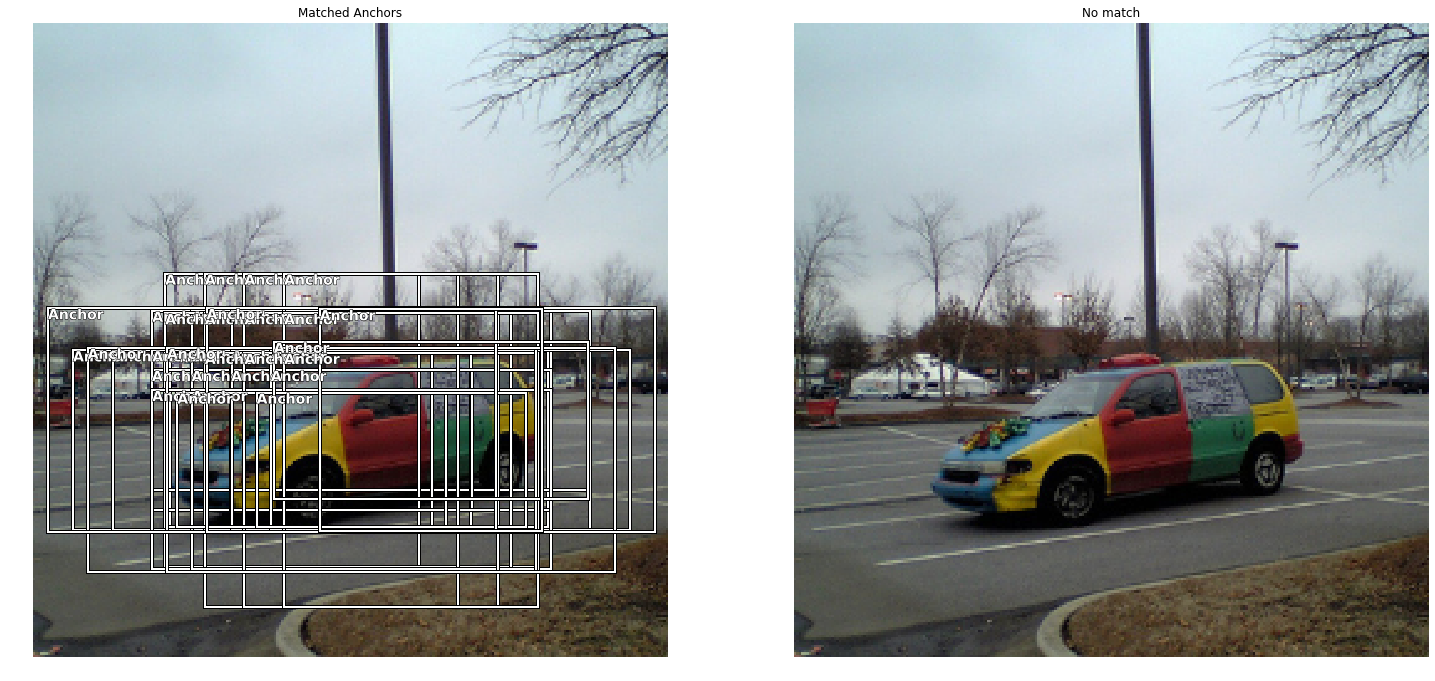

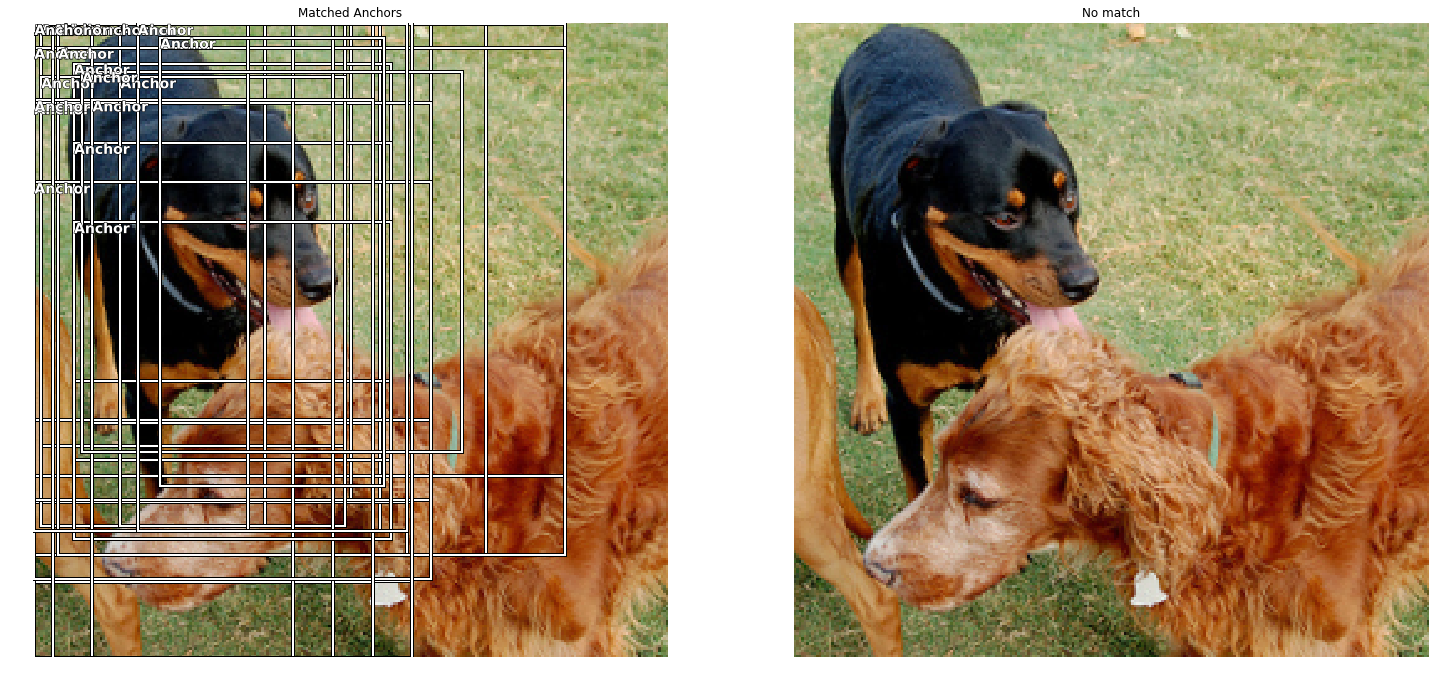

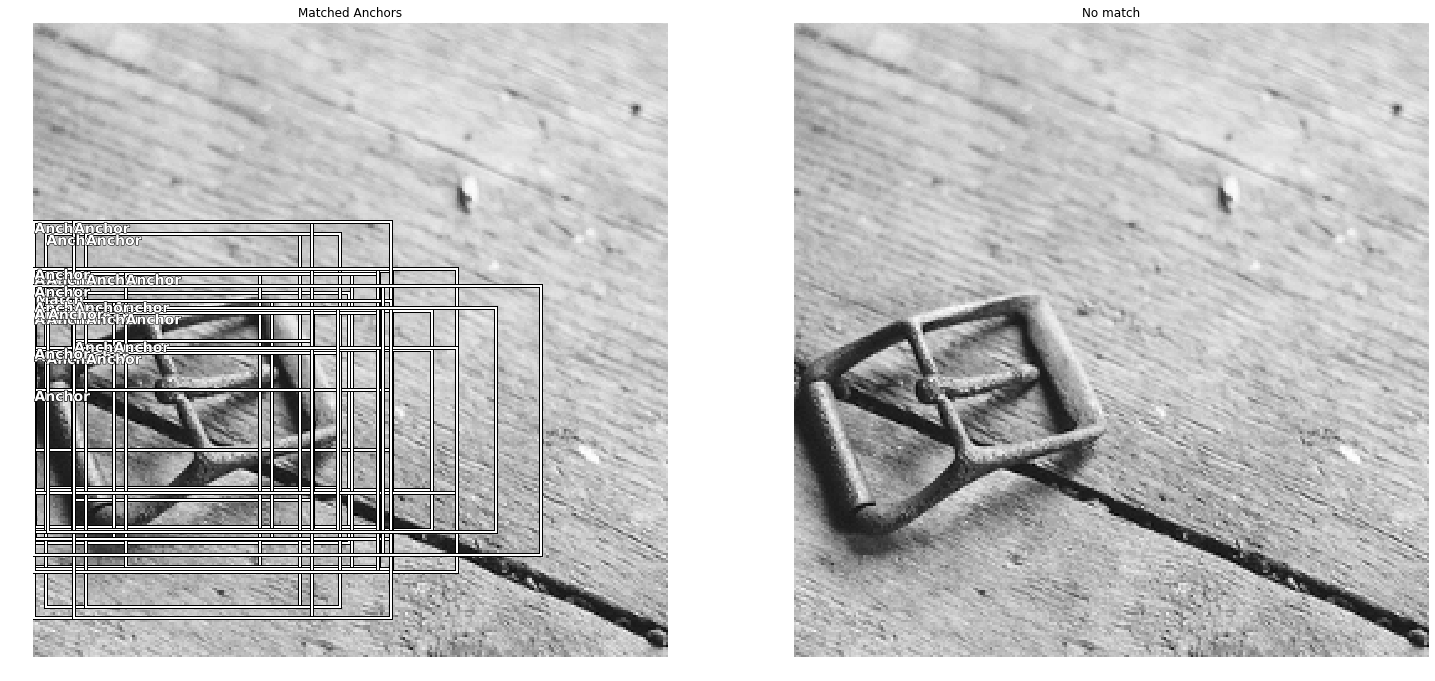

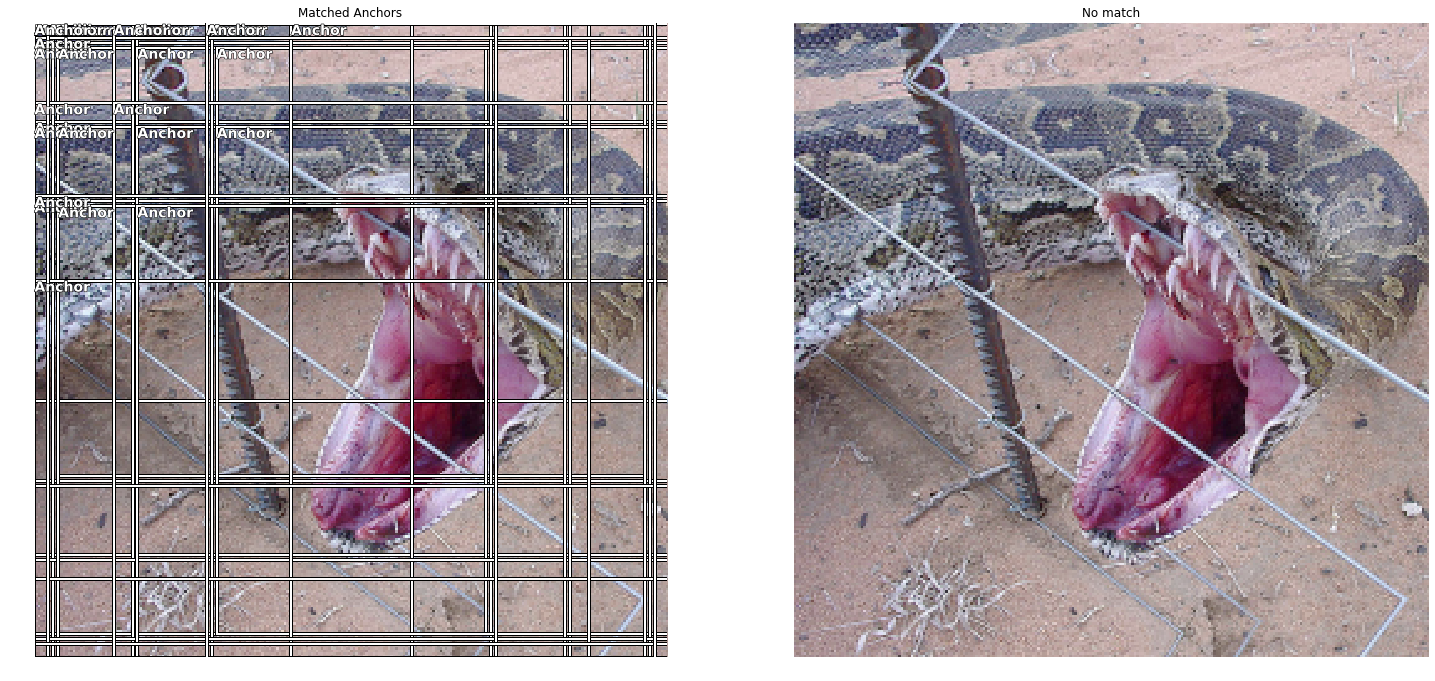

In [50]:
all_boxes, all_labels = show_anchors_on_images(data_bunch, anchors, figsize=(25,25))

### create learner with inceptionresnetv2 (the pytorch model is already pretrained on imagenet)

In [51]:
n_classes = data_bunch.train_ds.c

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2) 
#encoder = create_body(inception, True, -2)
model = RetinaNet(encoder, n_classes=data_bunch.train_ds.c, n_anchors=18, sizes=[32,16,8,4], chs=256, 
                  final_bias=-4., n_conv=2)

In [52]:
voc = PascalVOCMetric(anchors, size, [])
learn = Learner(data_bunch, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics], metrics=[voc])

In [53]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

In [54]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace)
   (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [55]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 747.12 MiB (GPU 0; 7.93 GiB total capacity; 5.02 GiB already allocated; 270.50 MiB free; 1.37 GiB cached)

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
lr = 1e-3

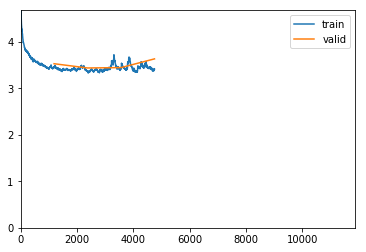

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(lr), div_factor=25)

In [ ]:
learn.save('256px_object_detection_frozen_smoll');

In [95]:
learn.load('256px_object_detection_frozen_smoll');

In [96]:
learn.unfreeze()

In [97]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-06


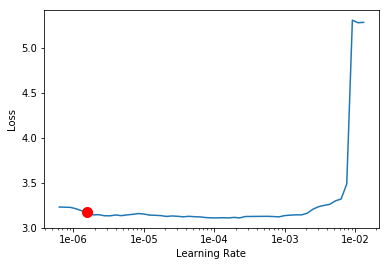

In [98]:
learn.recorder.plot(suggestion=True)

In [100]:
lr = 1e-3

In [101]:
lrs = learn.lr_range(slice(lr/2,lr))
lrs

array([0.0002  , 0.000283, 0.0004  ])

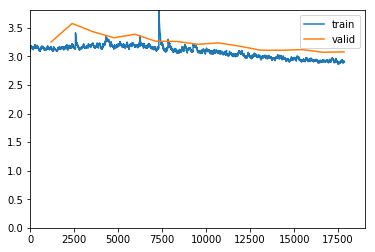

In [ ]:
learn.fit_one_cycle(16, max_lr=lrs, div_factor=50)

In [ ]:
learn.save('256px_object_detection_smoll');

In [ ]:
lr = 1e-4

In [ ]:
lrs = learn.lr_range(slice(lr,lr))
lrs

In [ ]:
learn.fit_one_cycle(20, max_lr=lrs, div_factor=100)

In [107]:
learn.save('256px_object_detection_smoll_continued');

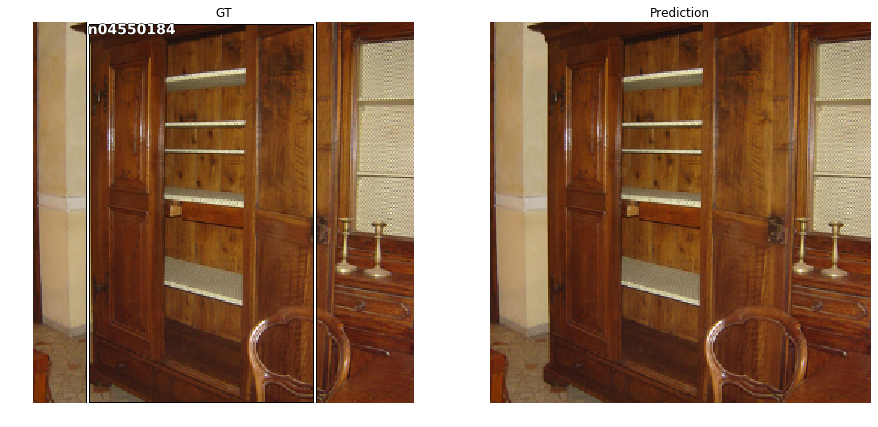

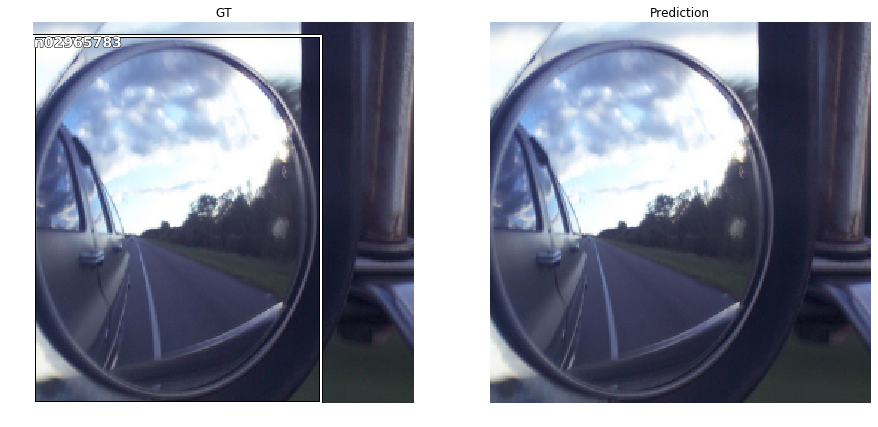

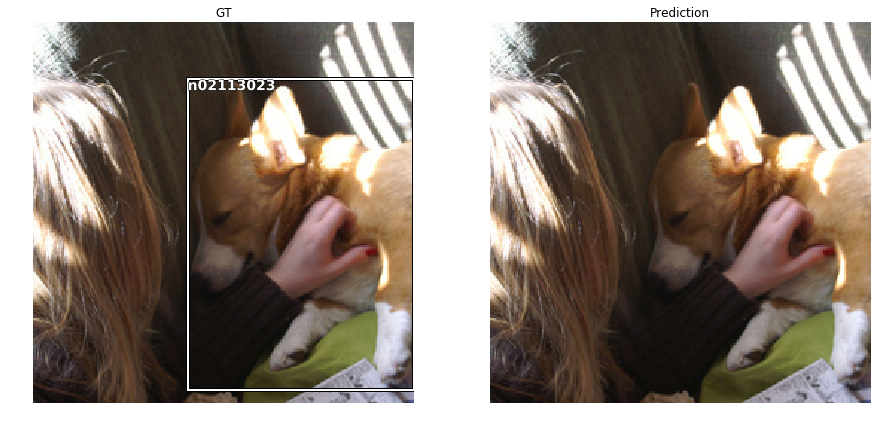

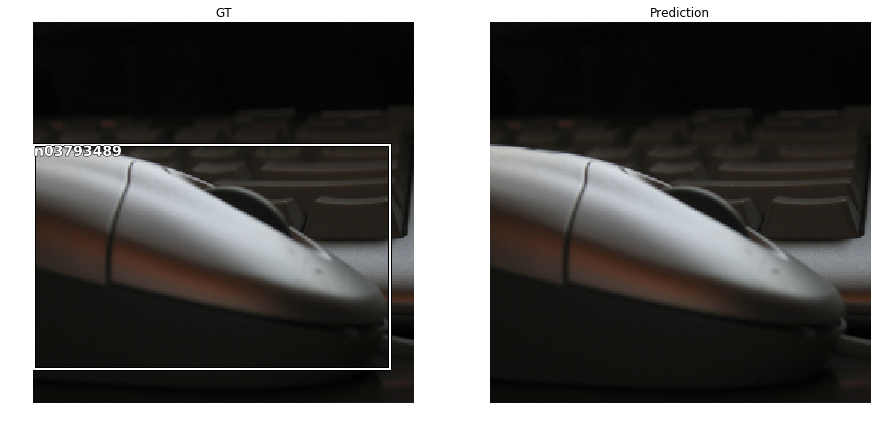

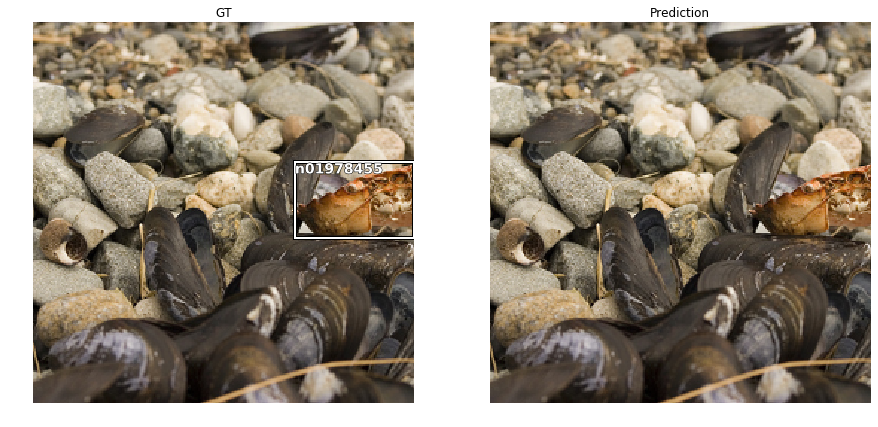

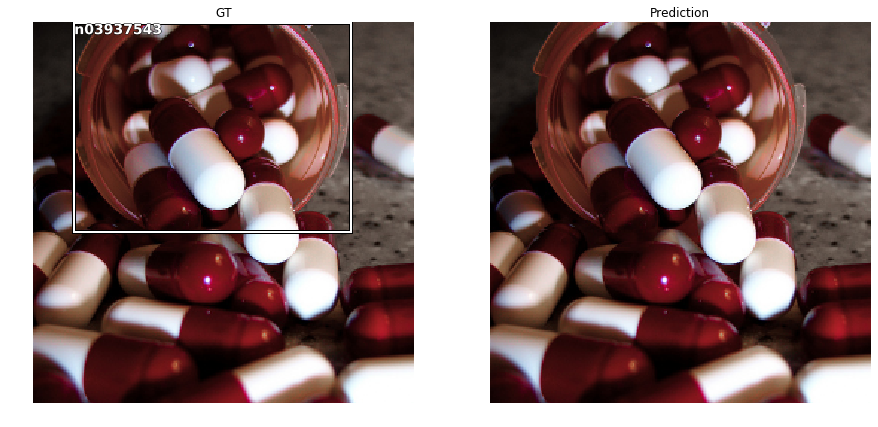

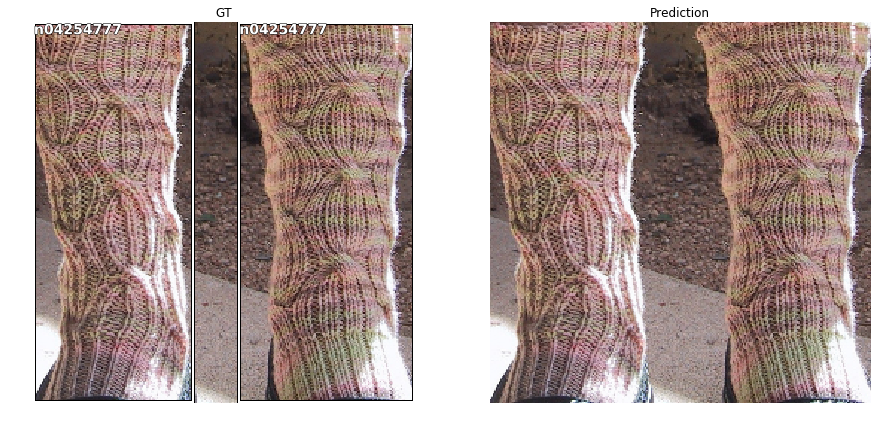

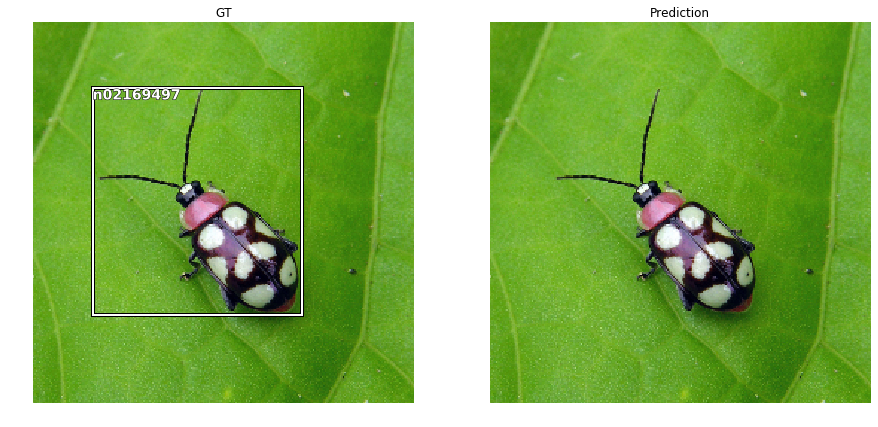

In [113]:
show_results_side_by_side(learn, anchors, detect_thresh=0.5, nms_thresh=0.1, image_count=25)

## interpret

In [ ]:
interpr = learn.interpret()

In [ ]:
interpr.plot_top_losses(4, figsize=(12,12))

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 1e-5

In [ ]:
lrs = learn.lr_range(slice(lr/9,lr))
lrs

In [ ]:
learn.fit_one_cycle(2, max_lr=lrs, div_factor=35)

In [ ]:
learn.save('299px_inceptionresnetv2_continued')

## prediction 

In [64]:
path

PosixPath('data/ILSVRC/Data/CLS-LOC')

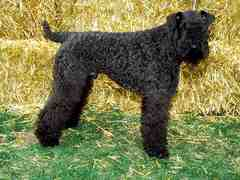

In [65]:
img = open_image(path/'train/n02093859/n02093859_1049.JPEG')
img

In [68]:
prob = learn.predict(img)

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
cl, label #, prob

In [ ]:
# Load Imagenet Synsets
with open('data/imagenet_synsets.txt', 'r') as f:
    synsets = f.readlines()

# len(synsets)==1001
# sysnets[0] == background
synsets = [x.strip() for x in synsets]
splits = [line.split(' ') for line in synsets]
key_to_classname = {spl[0]:' '.join(spl[1:]) for spl in splits}

In [ ]:
{k: key_to_classname[k] for k in list(key_to_classname)[:5]}

In [ ]:
key_to_classname[str(cl)]

In [ ]:
learn.export('export/export.pkl')

In [ ]:
learn = load_learner('export')